In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functions import Auction, MultiplicativePacingAgent, UCBLikeAgent



# Requirement 4

In [5]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        # ctrs = click-through rates (ad quality)
        self.ctrs = ctrs
        # assumed to be known by the auctioneer (can estimate them)
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # we compute the expected utility of each ad for the advertiser
        adv_values = self.ctrs * bids
        # sort the values in ascending order
        adv_ranking = np.argsort(adv_values)
        # the winner is chosen both based on its bid and the ad's ctr
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        # In a first-price auction, the winner pays their bid amount
        payment = bids[winners]
        return round(payment, 2)

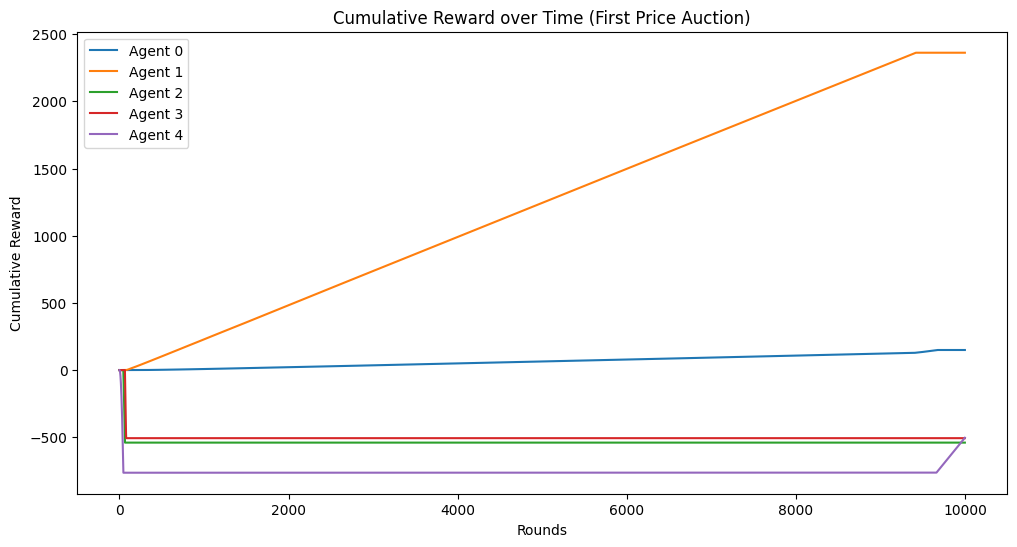

In [6]:
def run_simulation(n_advertisers, n_rounds, budget, base_valuation):
    ctrs = np.random.uniform(0.1, 1, n_advertisers)  # Random CTRs for each advertiser
    auction = FirstPriceAuction(ctrs)
    wins = [0 for i in range(n_advertisers)]
    
    agents = []
    for i in range(n_advertisers):
        if i < n_advertisers // 2:
            agents.append(MultiplicativePacingAgent(valuation=base_valuation, budget=budget, T=n_rounds, eta=0.1))
        else:
            agents.append(UCBLikeAgent(budget=budget, T=n_rounds, bids=np.linspace(0, base_valuation, 100)))

    rewards = {i: [] for i in range(n_advertisers)}
    cumulative_rewards = {i: [0] for i in range(n_advertisers)}

    for round in range(n_rounds):
        bids = [agent.bid() for agent in agents]
        
        winner, values = auction.get_winners(bids)
        payment = auction.get_payments_per_click(winner, values, bids)
        
        for i, agent in enumerate(agents):
            if i == winner:
                wins[i] += 1
                reward = ctrs[i] * (base_valuation - payment)
                agent.update(reward, payment)
                rewards[i].append(reward)
                cumulative_rewards[i].append(cumulative_rewards[i][-1] + reward)
            else:
                agent.update(0, 0)
                rewards[i].append(0)
                cumulative_rewards[i].append(cumulative_rewards[i][-1])

    return rewards, cumulative_rewards, wins

# Run the simulation
n_advertisers = 5
n_rounds = 10000
budget = 1000
base_valuation = 1

rewards, cumulative_rewards, wins = run_simulation(n_advertisers, n_rounds, budget, base_valuation)

# Plot results
plt.figure(figsize=(12, 6))
for i in range(len(cumulative_rewards)):
    plt.plot(cumulative_rewards[i], label=f'Agent {i}')

plt.title('Cumulative Reward over Time (First Price Auction)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [7]:
# Print number of wins and cumulative utilities for each agent
print("Agent Results:")
print("Agent\tWins\tCumulative Utility")
print("-----\t----\t------------------")
for i in range(n_advertisers):
    print(f"{i}\t{wins[i]}\t{cumulative_rewards[i][-1]:.2f}")

# Print total wins
total_wins = sum(wins)
print(f"\nTotal wins: {total_wins}")

# Print win percentages
print("\nWin Percentages:")
for i in range(n_advertisers):
    win_percentage = (wins[i] / total_wins) * 100
    print(f"Agent {i}: {win_percentage:.2f}%")

Agent Results:
Agent	Wins	Cumulative Utility
-----	----	------------------
0	2325	149.46
1	7260	2361.84
2	19	-539.81
3	14	-506.69
4	382	-503.85

Total wins: 10000

Win Percentages:
Agent 0: 23.25%
Agent 1: 72.60%
Agent 2: 0.19%
Agent 3: 0.14%
Agent 4: 3.82%
